<a href="https://colab.research.google.com/github/roliveira15/Data_Science_Sales_Forecast/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1) Carregando as bibliotecas

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

! pip install pmdarima
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline
from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 2) Importando o dataFrame

In [74]:
from google.colab import data_table
data_table.enable_dataframe_formatter()
#dateparse = lambda dates: pd.datetime.strptime(dates,'%d-%m-%Y') , parse_dates=['data'], index_col = 'data', date_parser=dateparse
df = pd.read_csv('https://raw.githubusercontent.com/roliveira15/Data_Science_Sales_Forecast/main/base.csv', sep = ';')
df.dtypes

tipo_frete                      object
peso                            object
valor_total_pedido              object
data                            object
abreviatura_uf                  object
regiao                          object
grupo_gerencial_produto         object
conta_numero_pedido_vendedor     int64
dtype: object

### 4) Converter o peso e o valor em float

Por padrão todas as variáveis do tipo string são armazenadas como object por esse motivo toda vez que tentamos modifcar de object para str, quando geramos o dtypes, as variáveis permanecem object. https://statisticsglobe.com/convert-object-data-type-string-pandas-dataframe-column-python





In [75]:

df['peso'] = df['peso'].str.replace(',','.').astype(float)
df['valor_total_pedido'] = df['valor_total_pedido'].str.replace(',','.').astype(float)

df['data'] = pd.to_datetime((df['data']))

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
dtype: object

In [76]:

conta_produto= df.groupby(['grupo_gerencial_produto','regiao']).count()

conta_produto

tipo_frete  peso  valor_total_pedido  data  \
grupo_gerencial_produto regiao                                                 
AUTOMACAO               Nordeste           7     7                   7     7   
                        Sudeste           18    18                  18    18   
                        Sul                7     7                   7     7   
AUTOPORTANTE            Exterior           3     3                   3     3   
                        Nordeste           6     6                   6     6   
...                                      ...   ...                 ...   ...   
TRANSELEVADORES         Sul                1     1                   1     1   
TUBOS                   Sul                1     1                   1     1   
UNIVERSAL               Nordeste           1     1                   1     1   
                        Sudeste          176   176                 176   176   
                        Sul               66    66                  66    66   

                                  abreviatura_uf  conta_numero_pedido_vendedor  
grupo_gerencial_produto regiao                                                  
AUTOMACAO               Nordeste               7                             7  
                        Sudeste               18                            18  
                        Sul                    7                             7  
AUTOPORTANTE            Exterior               3                             3  
                        Nordeste               6                             6  
...                                          ...                           ...  
TRANSELEVADORES         Sul                    1                             1  
TUBOS                   Sul                    1                             1  
UNIVERSAL               Nordeste               1                             1  
                        Sudeste              176                           176  
                        Sul                   66                            66  

[86 rows x 6 columns]

###5) Criar uma coluna de Ano e mês

In [77]:
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month

df.dtypes

tipo_frete                              object
peso                                   float64
valor_total_pedido                     float64
data                            datetime64[ns]
abreviatura_uf                          object
regiao                                  object
grupo_gerencial_produto                 object
conta_numero_pedido_vendedor             int64
ano                                      int64
mes                                      int64
dtype: object

### 6) Criando estrutura para gerar gráfico de estruturas por ano, mes em função de peso e valor_total_pedido

In [78]:
groupStructures = df.groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum()

groupStructures = groupStructures.round({'valor_total_pedido': 0,'peso': 0}).groupby(['grupo_gerencial_produto','ano','mes','data','tipo_frete','regiao','abreviatura_uf']).sum().reset_index()
groupStructures.loc[(groupStructures['valor_total_pedido'] > 0) & (groupStructures['data'] >= '2020-09-01')]


,grupo_gerencial_produto,ano,mes,data,tipo_frete,regiao,abreviatura_uf,peso,valor_total_pedido,conta_numero_pedido_vendedor
3,AUTOMACAO,2020,9,2020-09-10,CIF,Sudeste,ES,1343.0,79000.0,1
5,AUTOMACAO,2020,11,2020-11-08,CIF,Sudeste,ES,811.0,56550.0,1
6,AUTOMACAO,2021,1,2021-01-04,CIF,Sudeste,ES,3830.0,333060.0,1
7,AUTOMACAO,2021,1,2021-01-05,CIF,Nordeste,RN,8845.0,610800.0,1
8,AUTOMACAO,2021,3,2021-03-08,CIF,Sudeste,SP,2542.0,2052312.0,1
...,...,...,...,...,...,...,...,...,...,...
4558,UNIVERSAL,2023,5,2023-05-15,FOB,Sudeste,ES,6628.0,10605.0,1
4559,UNIVERSAL,2023,6,2023-06-02,FOB,Sudeste,ES,8721.0,13954.0,1
4560,UNIVERSAL,2023,6,2023-06-04,FOB,Sudeste,ES,4955.0,7928.0,1
4561,UNIVERSAL,2023,7,2023-07-03,FOB,Sudeste,ES,8695.0,13912.0,1


6.1) Declara as variáveis principais do produto, data e região

In [79]:
#PPint = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2024-01-01') & (groupStructures['regiao'] == 'Sudeste')]
PP = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2023-04-01') & (groupStructures['regiao'] == 'Sudeste')]
#PPanterior = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2021-01-01') & (groupStructures['data'] < '2022-01-01') & (groupStructures['regiao'] == 'Sudeste')]
#PPanteriorA = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2021-01-01') & (groupStructures['regiao'] == 'Sudeste')]

6.2) Criando gráfico por estrutura


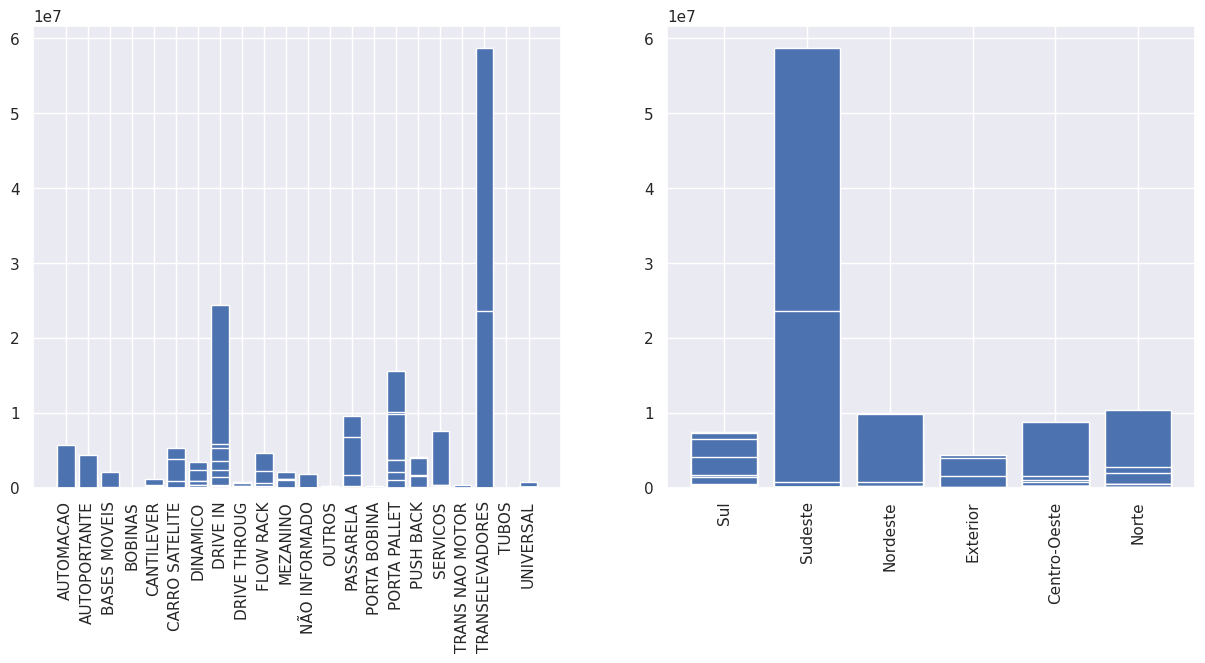

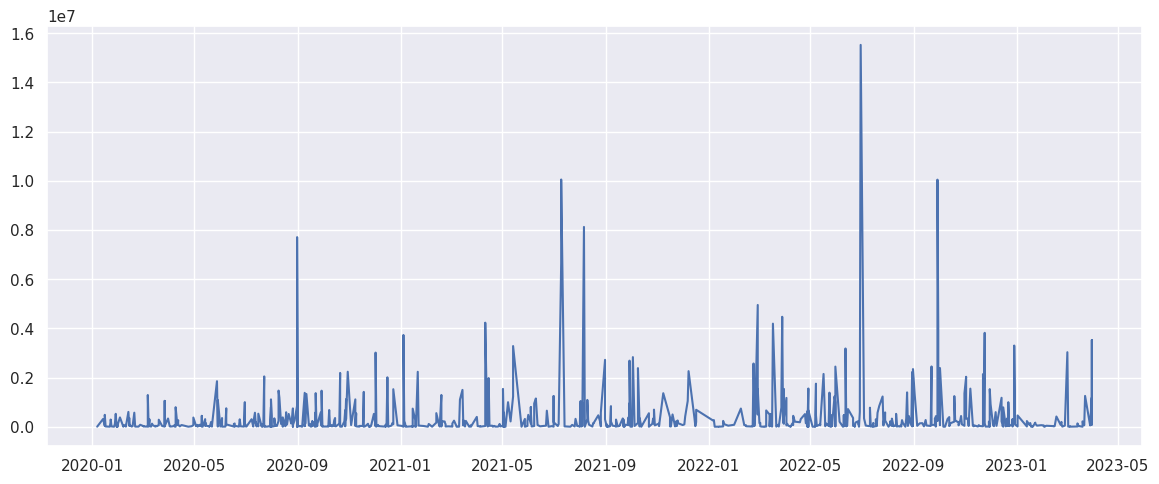

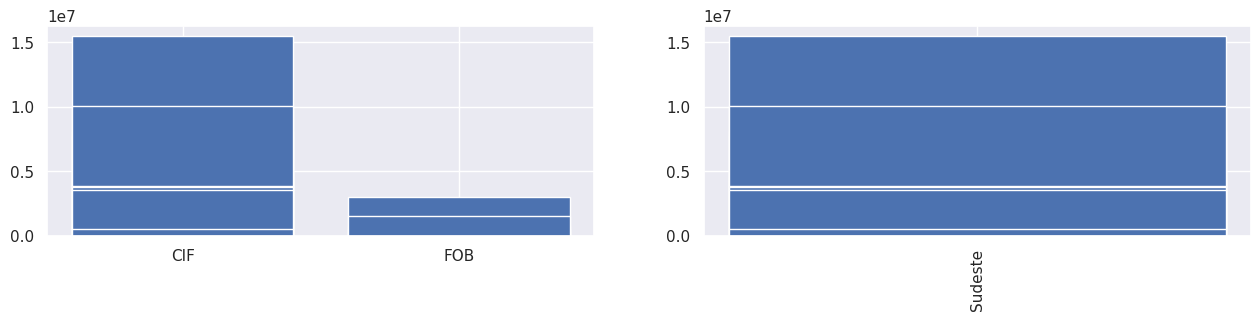

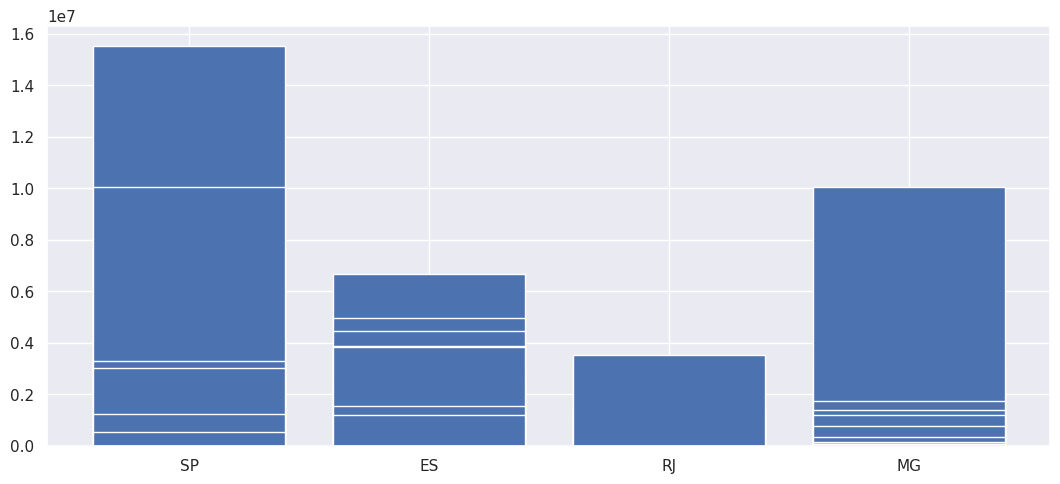

In [80]:

'''
                                  PORTA PALETE
'''
#Gráfico de barras de
plt.figure(figsize = ((15, 6)))
plt.subplot(1, 2, 1)
plt.bar(groupStructures['grupo_gerencial_produto'], groupStructures['valor_total_pedido'])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
plt.bar(groupStructures['regiao'], groupStructures['valor_total_pedido'])
plt.xticks(rotation=90)

plt.figure(figsize = ((48, 12)))
#Anual
plt.subplot(2, 3, 3)
plt.plot(PP['data'],PP['valor_total_pedido'])
#plt.plot(PPanterior['mes'],PPanterior['valor_total_pedido'],color='red')
#plt.plot(PPanteriorA['mes'],PPanteriorA['valor_total_pedido'],color='green')
plt.show()

plt.figure(figsize = ((24, 6)))
#Tipo de frete
plt.subplot(2, 3, 1)
plt.bar(PP['tipo_frete'], PP['valor_total_pedido'])
#Região
plt.subplot(2, 3, 2)
plt.bar(PP['regiao'], PP['valor_total_pedido'])
plt.xticks(rotation=90)
#Estado
plt.figure(figsize = ((44, 12)))
plt.subplot(2, 3, 4)
plt.bar(PP['abreviatura_uf'],PP['valor_total_pedido'])
plt.show()




<Axes: >

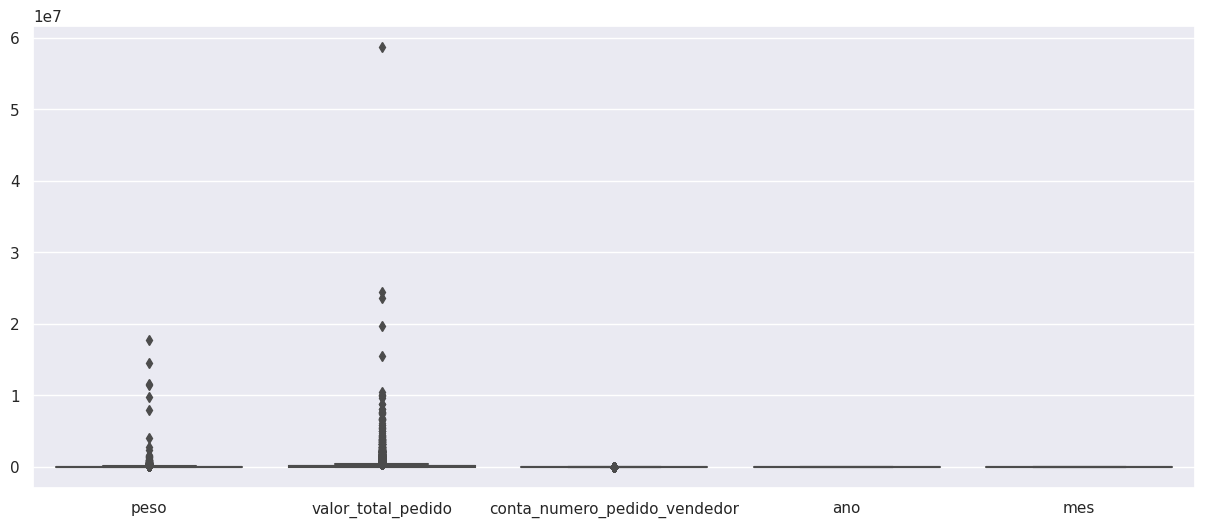

In [81]:


sns.set()

#sns.boxplot(data=groupStructures['grupo_gerencial_produto','valor_total_pedido'],y='vlr',showfliers=True,color='pink');
sns.boxplot(data=df,orient='v',showfliers=True)

Realizar a plotagem de todos os grupos para entender o comportadomento dos gráficos

In [82]:

modelo_preditivo = groupStructures.loc[(groupStructures['grupo_gerencial_produto'] == 'PORTA PALLET') & (groupStructures['data'] >= '2020-01-01') & (groupStructures['data'] < '2023-05-01') & (groupStructures['regiao'] == 'Sudeste') ]

modelo_preditivo['data_agrupada'] =  modelo_preditivo['ano'].map(str)+ '-' + modelo_preditivo['mes'].map(str) + '-01'

modelo_preditivo['data_agrupada'] = pd.to_datetime((modelo_preditivo['data_agrupada']))

modelo_preditivo = modelo_preditivo.drop(columns=['data','peso','conta_numero_pedido_vendedor','mes','ano']).round({'valor_total_pedido': 0}).groupby(['data_agrupada']).sum()

modelo_preditivo.index.names = ['data_agrupada']

#modelo_preditivo['valor_total_pedido_TESTE'] = modelo_preditivo['valor_total_pedido'].rolling(window = 5).mean()

#modelo_preditivo['valor_total_pedido'] = modelo_preditivo['valor_total_pedido'].ewm(span=4).mean()
#modelo_preditivo.dropna(subset=['valor_total_pedido'],inplace=True)
display(modelo_preditivo)


<ipython-input-82-4b123e39044c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo_preditivo['data_agrupada'] =  modelo_preditivo['ano'].map(str)+ '-' + modelo_preditivo['mes'].map(str) + '-01'
<ipython-input-82-4b123e39044c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo_preditivo['data_agrupada'] = pd.to_datetime((modelo_preditivo['data_agrupada']))
<ipython-input-82-4b123e39044c>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, 

,valor_total_pedido
data_agrupada,
2020-01-01,2133848.0
2020-02-01,2287301.0
2020-03-01,3783363.0
2020-04-01,1920012.0
2020-05-01,4775984.0
2020-06-01,3104653.0
2020-07-01,8079227.0
2020-08-01,17168182.0
2020-09-01,8576807.0


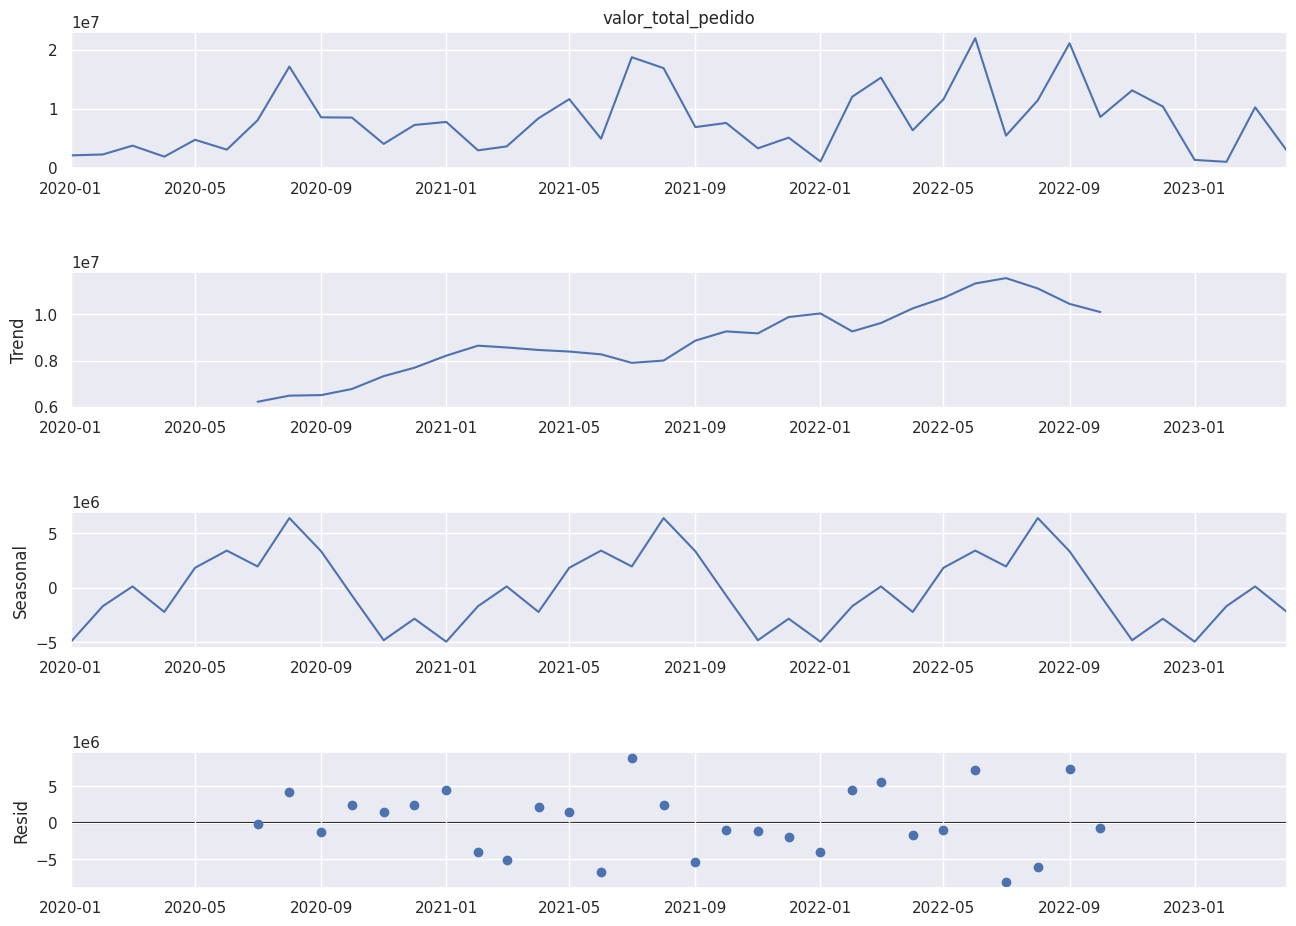

In [83]:


results = seasonal_decompose(x=modelo_preditivo['valor_total_pedido'])#,model='multiplicative',period=12)

#calcular o desvio padrão(próximo de 1) e a média (próximo de zero), ou seja, não posso ter esses dados muitos espalhos, porque vou estar errando muito longe
desvio_pad_ruido = results.resid

fig = results.plot()
fig.set_size_inches(13, 10)

In [84]:
from statsmodels.tsa.stattools import adfuller
# Teste de Dickey Fuller
result = adfuller(results.observed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] < 0.05:
    print('É Estacionário!')
else:
    print('Não é Estacionário!')




ADF Statistic: -3.378177
p-value: 0.011726
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
É Estacionário!


/usr/local/lib/python3.10/dist-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


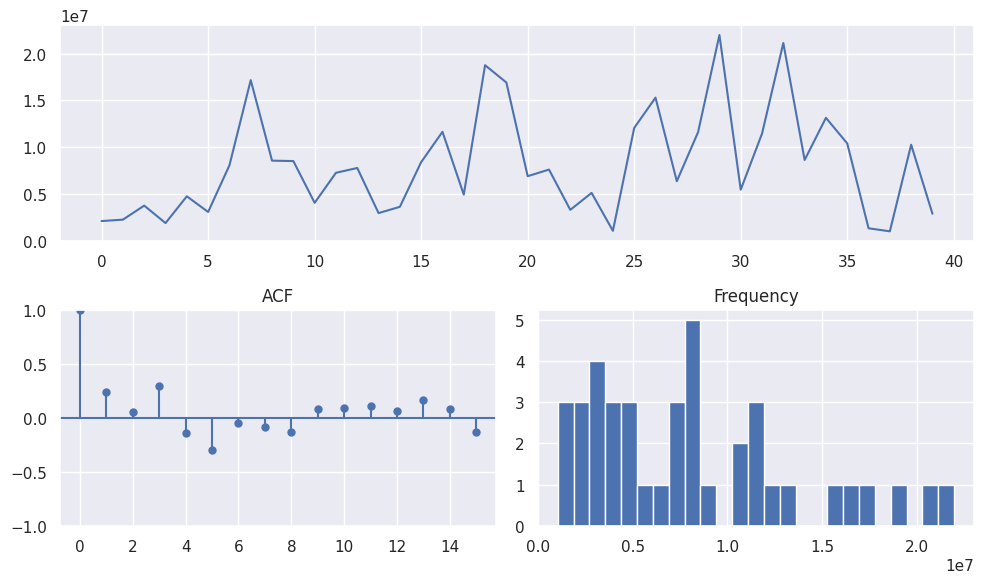

In [85]:
tsdisplay(results.observed,lag_max=15,figsize=(10,6))

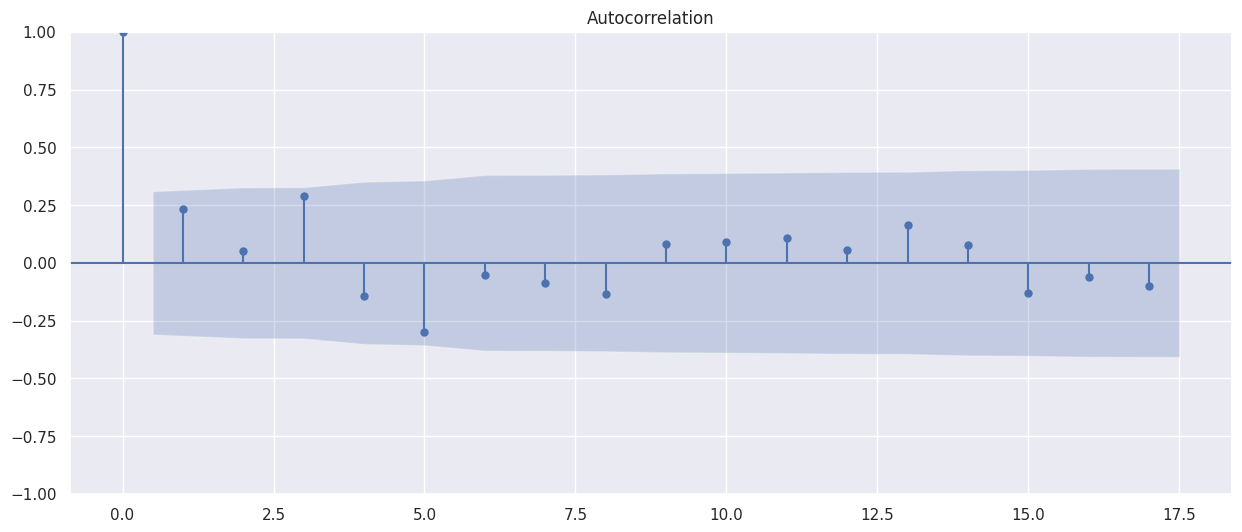

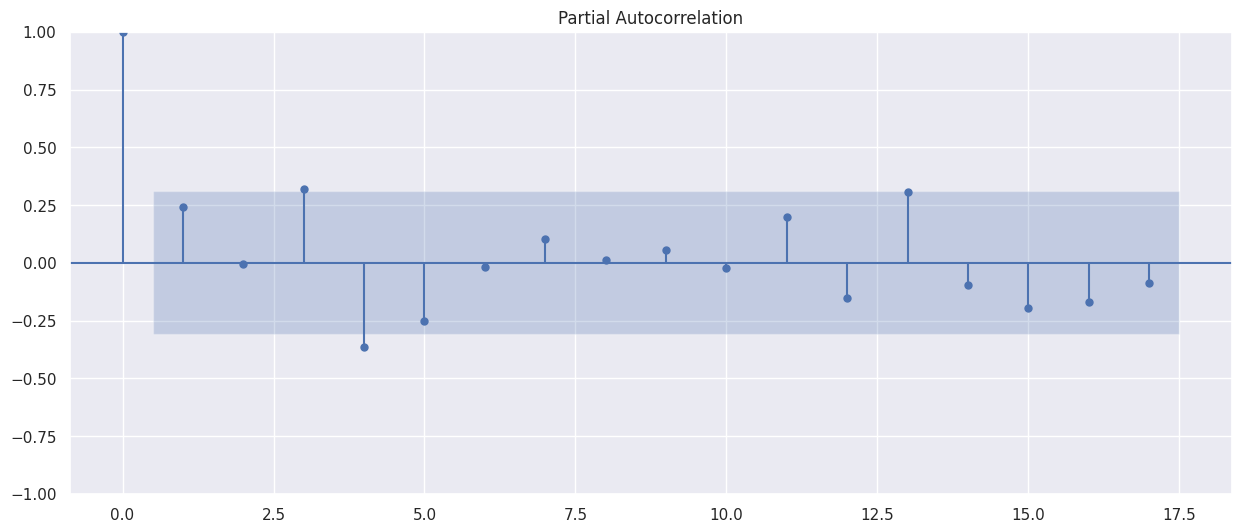

In [86]:
plot_acf(results.observed, alpha=0.05);
plot_pacf(results.observed, alpha=0.05);

<Axes: >

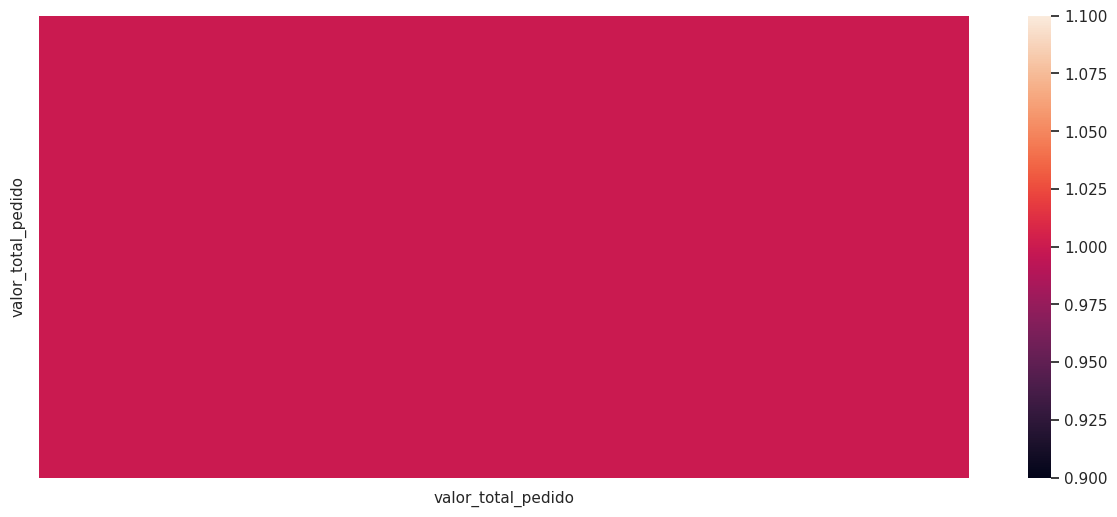

In [87]:
import seaborn as sn
correlation = modelo_preditivo.corr()

plot = sn.heatmap(correlation)
plot

In [88]:
stepwise=auto_arima(results.observed,
                    start_p=1,
                    start_q=2,
                    d=0,
                    max_p=6,
                    max_q=6,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=971.282, Time=0.81 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=966.982, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=967.682, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=966.769, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=968.561, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=969.174, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=968.730, Time=0.17 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=968.431, Time=0.18 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=968.341, Time=0.11 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=969.416, Time=0.35 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=963.771, Time=0.08 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=965.651, Time=0.12 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=965.554, Time=0.17 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=965.745, Time=0.08 sec
 ARIMA(0,0,0)(1,1,2)[12] intercep

In [89]:
stepwise

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [90]:
print(stepwise.aic())
print(stepwise.bic())
display(stepwise.summary())

963.7710470540125
967.767660584538


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                          y   No. Observations:                   40
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -478.886
Date:                    Mon, 03 Jul 2023   AIC                            963.771
Time:                            01:25:04   BIC                            967.768
Sample:                        01-01-2020   HQIC                           964.993
                             - 04-01-2023                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.706e+06   9.49e+05      1.796      0.072   -1.55e+05    3.57e+06
ma.S.L12      -0.6015      0.496     -1.212      0.225      -1.574       0.371
sigma2      5.057e+13      0.035   1.44e+15      0.000    5.06e+13    5.06e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.90   Prob(JB):                         0.63
Heteroskedasticity (H):               1.59   Skew:                             0.40
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.16e+30. Standard errors may be unstable.
"""

In [91]:
PPtreino = results.observed.loc['2020-01-01':'2022-01-01']

PPtest = results.observed.loc['2022-01-01':]

display(PPtest)

data_agrupada
2022-01-01     1092852.0
2022-02-01    12066025.0
2022-03-01    15300644.0
2022-04-01     6384801.0
2022-05-01    11628771.0
2022-06-01    21982237.0
2022-07-01     5481328.0
2022-08-01    11462899.0
2022-09-01    21126865.0
2022-10-01     8648332.0
2022-11-01    13147581.0
2022-12-01    10412239.0
2023-01-01     1364166.0
2023-02-01     1040547.0
2023-03-01    10275230.0
2023-04-01     2914564.0
Name: valor_total_pedido, dtype: float64

In [92]:
stepwise.fit(PPtreino)


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [93]:
previsao = stepwise.predict(n_periods=len(PPtest))

previsao.index = PPtest.index
display(previsao)



data_agrupada
2022-01-01    4.585373e+06
2022-02-01    5.330292e+06
2022-03-01    9.367109e+06
2022-04-01    1.252219e+07
2022-05-01    6.417996e+06
2022-06-01    1.915151e+07
2022-07-01    1.843059e+07
2022-08-01    8.708860e+06
2022-09-01    9.330914e+06
2022-10-01    5.073916e+06
2022-11-01    6.998761e+06
2022-12-01    3.490484e+06
2023-01-01    6.102960e+06
2023-02-01    6.847879e+06
2023-03-01    1.088470e+07
2023-04-01    1.403978e+07
dtype: float64

<Figure size 2000x500 with 0 Axes>

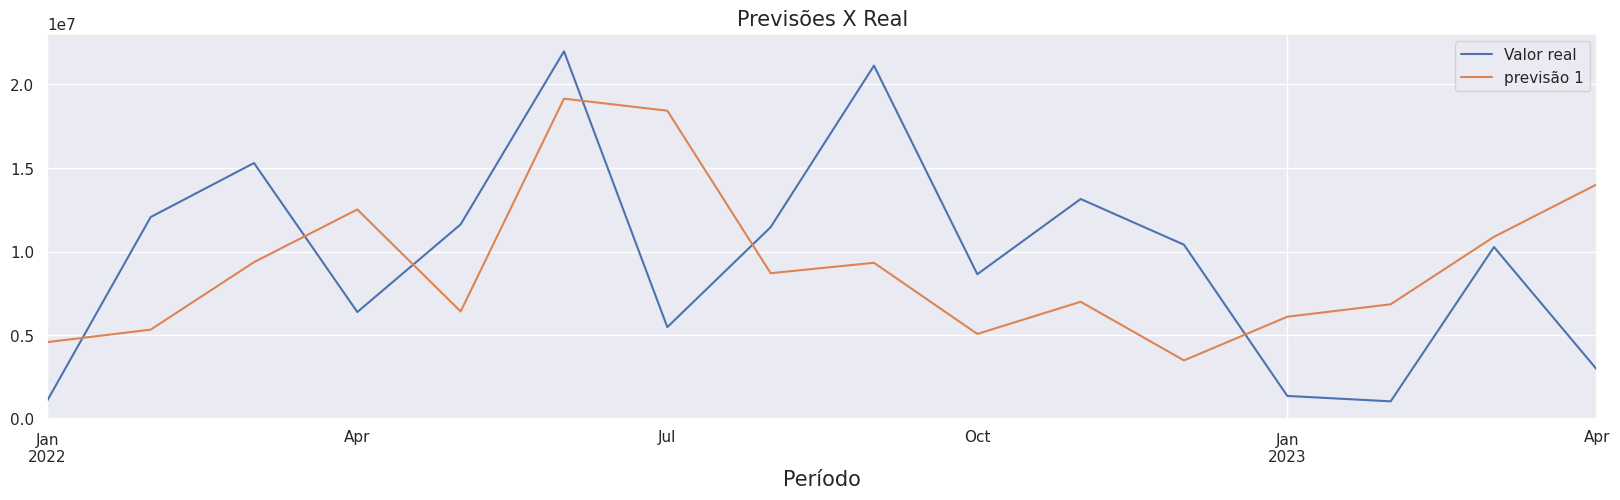

In [94]:
plt.figure(figsize=(20,5))
pd.concat([PPtest,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Valor real','previsão 1','previsão 2']);



<Figure size 2000x500 with 0 Axes>

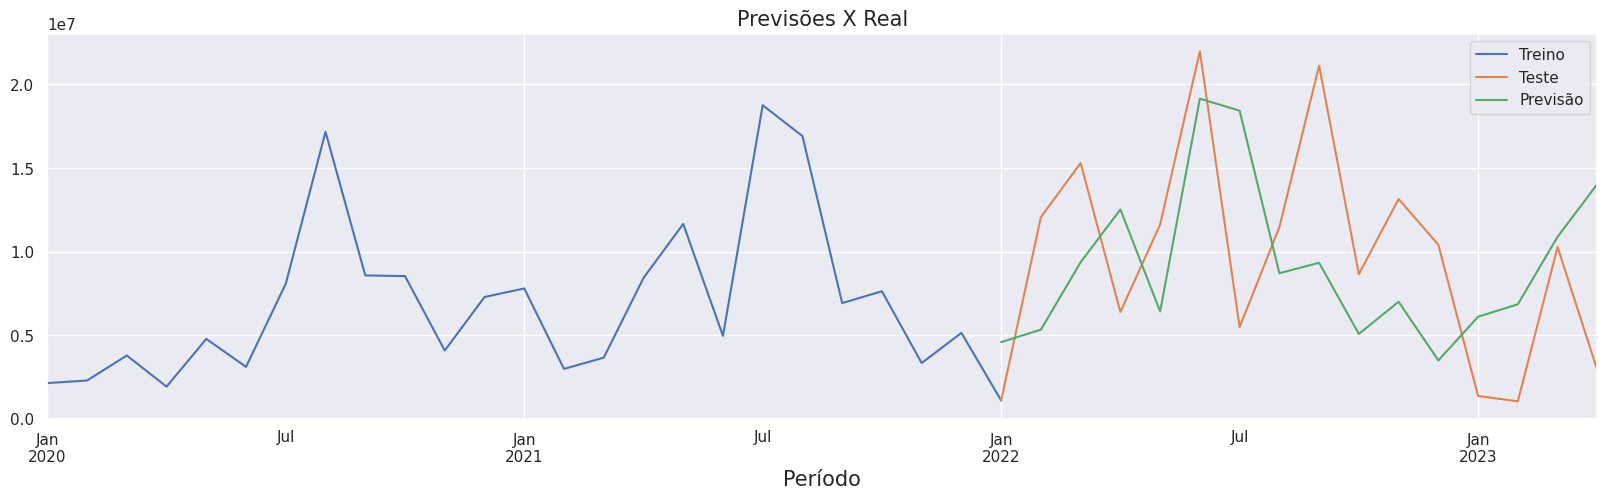

In [95]:
plt.figure(figsize=(20,5))
pd.concat([PPtreino,PPtest,previsao],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.xlabel("Período", size=15)
plt.legend(['Treino','Teste','Previsão']);


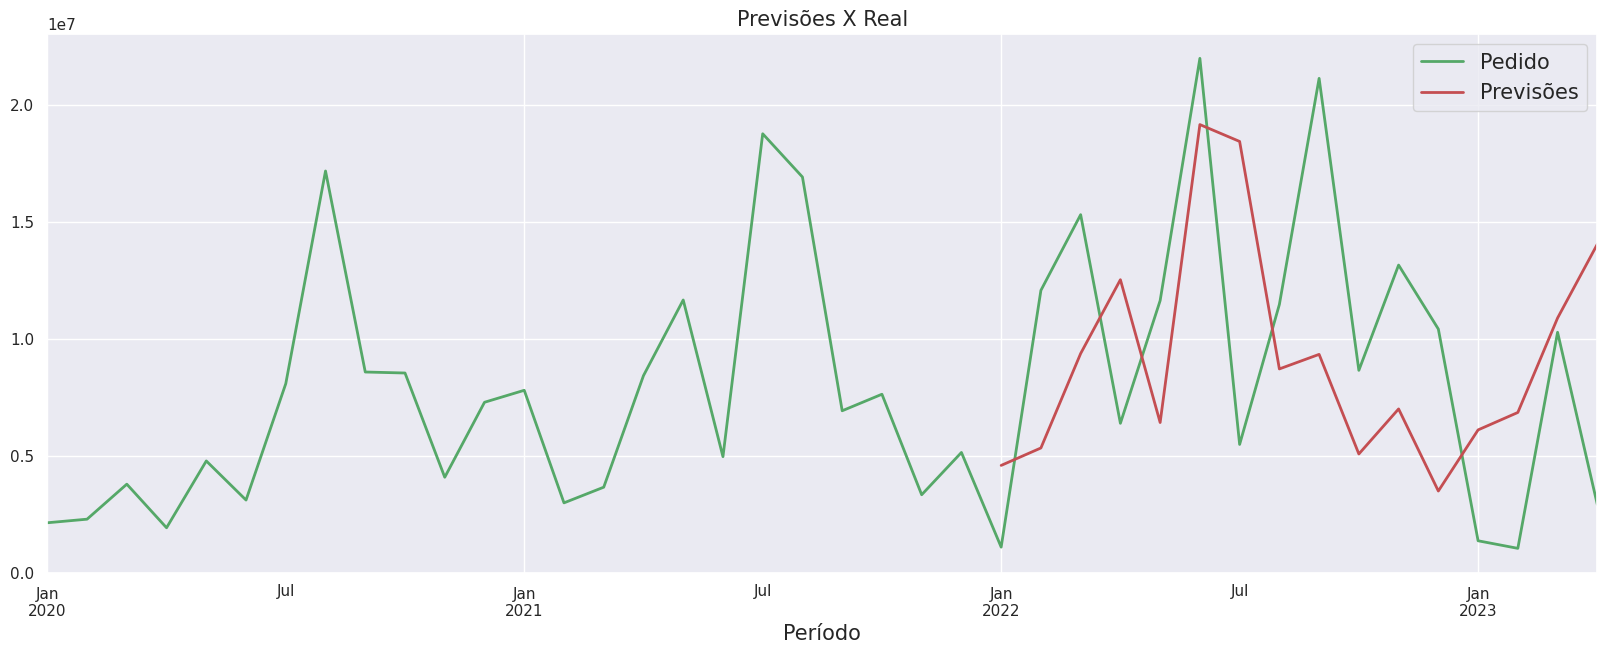

In [96]:
pd.concat([results.observed,previsao],
          axis=1).plot(linewidth=2,
                       figsize=(20,7),
                       color=['g','r'])
plt.legend(['Pedido','Previsões'], fontsize=15)
plt.xlabel('Período', size=15)
plt.title('Previsões X Real',size=15)
plt.show();




In [97]:
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [131]:

model = SARIMAX(previsao,order=(0,0,0),  seasonal_order=(0, 1, 1, 12))
resultado_sarimax = model.fit()
forecast = resultado_sarimax.get_forecast(steps=12)
forecast_medio = forecast.predicted_mean
print(forecast_medio)
print(previsao)

2023-05-01    6.417996e+06
2023-06-01    1.915151e+07
2023-07-01    1.843059e+07
2023-08-01    8.708860e+06
2023-09-01    9.330914e+06
2023-10-01    5.073916e+06
2023-11-01    6.998761e+06
2023-12-01    3.490484e+06
2024-01-01    4.585373e+06
2024-02-01    5.330292e+06
2024-03-01    9.367109e+06
2024-04-01    1.252219e+07
Freq: MS, Name: predicted_mean, dtype: float64
data_agrupada
2022-01-01    4.585373e+06
2022-02-01    5.330292e+06
2022-03-01    9.367109e+06
2022-04-01    1.252219e+07
2022-05-01    6.417996e+06
2022-06-01    1.915151e+07
2022-07-01    1.843059e+07
2022-08-01    8.708860e+06
2022-09-01    9.330914e+06
2022-10-01    5.073916e+06
2022-11-01    6.998761e+06
2022-12-01    3.490484e+06
2023-01-01    6.102960e+06
2023-02-01    6.847879e+06
2023-03-01    1.088470e+07
2023-04-01    1.403978e+07
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [122]:

datas_forecast = np.asarray(forecast_medio.index)
pred_dates=np.asarray(previsao.index)

print(pred_dates)

['2022-01-01T00:00:00.000000000' '2022-02-01T00:00:00.000000000'
 '2022-03-01T00:00:00.000000000' '2022-04-01T00:00:00.000000000'
 '2022-05-01T00:00:00.000000000' '2022-06-01T00:00:00.000000000'
 '2022-07-01T00:00:00.000000000' '2022-08-01T00:00:00.000000000'
 '2022-09-01T00:00:00.000000000' '2022-10-01T00:00:00.000000000'
 '2022-11-01T00:00:00.000000000' '2022-12-01T00:00:00.000000000'
 '2023-01-01T00:00:00.000000000' '2023-02-01T00:00:00.000000000'
 '2023-03-01T00:00:00.000000000' '2023-04-01T00:00:00.000000000']


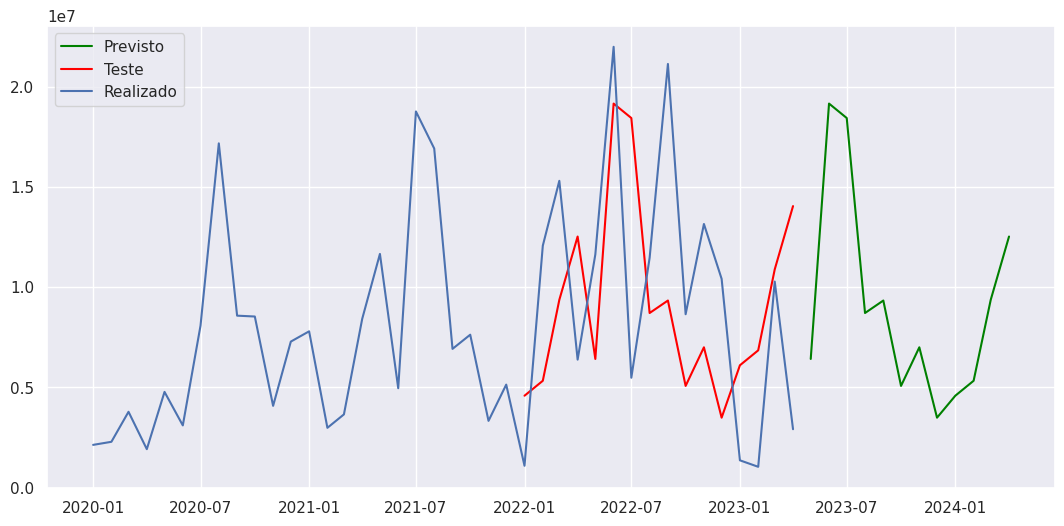

In [133]:
dates=np.asarray(modelo_preditivo.index)



plt.figure(figsize=(13,6))
plt.plot(datas_forecast,forecast_medio.values,color='green',label='Previsto')
plt.plot(previsao.index,previsao.values,color='red',label='Teste')

plt.plot(dates,modelo_preditivo.values, label='Realizado')
plt.legend(loc='upper left')
plt.show()

In [ ]:
#from sklearn.metrics import mean_squared_error, r2_score
#r2_score(results.observed, previsao)

Ajustando

In [ ]:
#previsao2=stepwise.predict(n_periods=6)
#previsao2=pd.DataFrame(future_forecast2,
 #                             index=pd.date_range(start='2021-06-01',end='2022-05-01', freq='MS'),                            columns=['nova previsão'])